In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import model_report as mr
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
file_info = "C:\\Users\\blgai\\OneDrive\\Documents\\School\\SMU\\Courses\\Fall 2021\\Capstone A\Data\\cleaned_chunked_v2.csv"
df = pd.read_csv(file_info, sep='\t')

In [3]:
df.groupby(df.category).size()

category
bu    11731
dr     1595
ed     3894
mk     8775
os     6789
sp     2535
sx     6557
dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
#get 10% holdout set
train_corpus, holdout_corpus, train_label, holdout_label = train_test_split(df['clean_comp_nouns'], 
                                                                           df['category'],
                                                                           test_size=.10,random_state=1234)

#get 80% train and 20% test sets
train_corpus, test_corpus, train_label, test_label = train_test_split(train_corpus,
                                                                      train_label,
                                                                      test_size=.2225,random_state=1234) #.9 * .2225 = .20

train_corpus.shape, test_corpus.shape, holdout_corpus.shape

((29302,), (8386,), (4188,))

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

#build BOW features on train corpus
tv = TfidfVectorizer(use_idf=True, min_df=25,max_df=.9, norm="l2",smooth_idf=True)
tv_train_features = tv.fit_transform(train_corpus)
#transform test corpus into features
tv_test_features = tv.transform(test_corpus)
#transform holdout corpus into features
tv_holdout_features = tv.transform(holdout_corpus)

print('TFIDF model:> Train features shape:',tv_train_features.shape,'Test features shape:',tv_test_features.shape,'Holdout features shape:',tv_holdout_features.shape)

TFIDF model:> Train features shape: (29302, 17587) Test features shape: (8386, 17587) Holdout features shape: (4188, 17587)


In [6]:
#Let's find the top important features and analyze them

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_opt=SelectKBest(chi2, k=4100)
tv_train_features_trimmed = X_opt.fit_transform(tv_train_features, train_label)
tv_train_features_trimmed.shape

(29302, 4100)

In [7]:
#create a data frame that includes all features and whether or not they are deemed important by feature_selection
feat_imp = pd.DataFrame(list(zip(tv.get_feature_names(),X_opt.get_support().tolist())),columns = ['Features','Important'])
feat_imp[feat_imp.Important == True]

,Features,Important
2,aaliyah,True
11,abby,True
15,abella,True
17,abigail,True
27,abroad,True
...,...,...
17540,zamnesia,True
17542,zapp,True
17554,zen,True
17569,zoe,True


In [8]:
#Now we can grab the important features so that we can select only the important features from the sparse matrix created by TfidfVectorizer
imp_Feats_array = np.array(feat_imp[feat_imp.Important == True].index)

In [9]:
#Now we can pull only the important features out of the original train, test, and holdout matrices
tv_train_features_sub = tv_train_features[:,imp_Feats_array]
tv_test_features_sub = tv_test_features[:,imp_Feats_array]
tv_holdout_features_sub = tv_holdout_features[:,imp_Feats_array]

#Examine the new shapes of the sub-selected features
print('TFIDF model:> Train features shape:',tv_train_features_sub.shape,'Test features shape:',tv_test_features_sub.shape,'Holdout features shape:',tv_holdout_features_sub.shape)

TFIDF model:> Train features shape: (29302, 4100) Test features shape: (8386, 4100) Holdout features shape: (4188, 4100)


In [10]:
%%time

from sklearn import svm
clf = svm.SVC(kernel='linear', probability=True, C=1.0, class_weight={'dr':8,'sx':10},random_state=1234)
clf.fit(tv_train_features_sub,train_label)

Wall time: 16min 14s


SVC(class_weight={'dr': 8, 'sx': 10}, kernel='linear', probability=True,
    random_state=1234)

In [11]:
svm_tfidf_test_score = clf.score(tv_test_features_sub,test_label)
print('Test Accuracy:',svm_tfidf_test_score)

Test Accuracy: 0.8637014071070832


In [12]:
import model_evaluation_utils as meu
svm_predictions = clf.predict(tv_test_features_sub)
meu.get_metrics(true_labels=test_label,predicted_labels=svm_predictions)

Accuracy: 0.8637
Precision: 0.8668
Recall: 0.8637
F1 Score: 0.8645


In [13]:
unique_classes = list(set(test_label))
meu.display_classification_report(true_labels=test_label,predicted_labels=svm_predictions,classes=unique_classes)

              precision    recall  f1-score   support

          sp       0.91      0.87      0.89       494
          bu       0.86      0.87      0.86      2355
          sx       0.99      0.99      0.99      1345
          os       0.86      0.78      0.82      1393
          ed       0.92      0.87      0.90       783
          mk       0.73      0.80      0.76      1709
          dr       0.98      0.95      0.96       307

    accuracy                           0.86      8386
   macro avg       0.89      0.88      0.88      8386
weighted avg       0.87      0.86      0.86      8386



Confusion matrix, without normalization
[[1091   20    4   11  193    1   73]
 [   5  683    0    8   32    0   55]
 [   5    0  291    0    6    1    4]
 [  12    5    0  429   40    3    5]
 [  97   16    1   22 1370    1  202]
 [   0    0    0    1    6 1338    0]
 [  55   19    2    3  231    4 2041]]


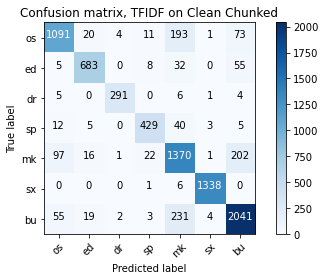

In [14]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_label,svm_predictions,labels=['os','ed','dr','sp','mk','sx','bu'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mr.plot_confusion_matrix(cnf_matrix, classes=['os','ed','dr','sp','mk','sx','bu'],
                      title='Confusion matrix, TFIDF on Clean Chunked')

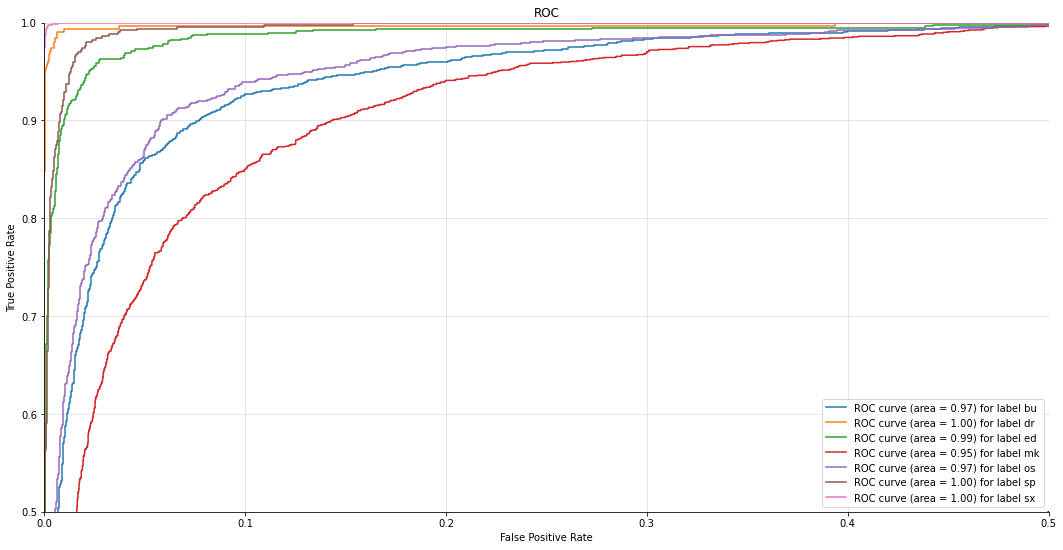

In [16]:
y_proba = clf.predict_proba(tv_test_features_sub)

labels_dict = dict(zip(df.category,df.category))
target_names = sorted(list(labels_dict.values()))

mr.plot_roc_curve(labels=test_label, predictions=y_proba, x_lim=[0.0,0.5], y_lim=[0.5,1.0], target_names=target_names)

In [18]:
df_test_results = pd.DataFrame(list(zip(test_corpus,test_label,svm_predictions, y_proba)),columns = ['terms','category','predicted_label','probability'])
df_test_results['match'] = np.where(df_test_results['category']==df_test_results['predicted_label'],1,0)

In [19]:
rpt = mr.generate_report(df_test_results)
rpt

{'totalSamples': 8386,
 'overallAccuracy': 0.8637014071070832,
 'byCategory': {'sx': {'totalSamples': 1345, 'accuracy': 0.9947955390334573},
  'dr': {'totalSamples': 307, 'accuracy': 0.9478827361563518},
  'ed': {'totalSamples': 783, 'accuracy': 0.8722860791826309},
  'sp': {'totalSamples': 494, 'accuracy': 0.868421052631579},
  'bu': {'totalSamples': 2355, 'accuracy': 0.8666666666666667},
  'mk': {'totalSamples': 1709, 'accuracy': 0.8016383850204798},
  'os': {'totalSamples': 1393, 'accuracy': 0.7832017229002154}}}

In [20]:
#here we can see that the misclassifications of sex equate to the counts in the confusion matrix
df_test_results[(df_test_results.predicted_label == 'sx') & (df_test_results.match == 0)].groupby('category').size()

category
bu    4
dr    1
mk    1
os    1
sp    3
dtype: int64

In [21]:
#let's look at some of the misclassifications to get an idea of why they were misclassified
pd.set_option('display.max_colwidth', None)
df_test_results[(df_test_results.predicted_label == 'sx') & (df_test_results.match == 0)]

terms  \
1787                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [22]:
support_vectors = clf.support_
print(support_vectors)

[   38    46    50 ... 28924 29131 29198]


In [23]:
# Get number of support vectors per class
support_vectors_per_class = clf.n_support_
print(support_vectors_per_class)

[3448  183 1105 3918 2604  755  366]


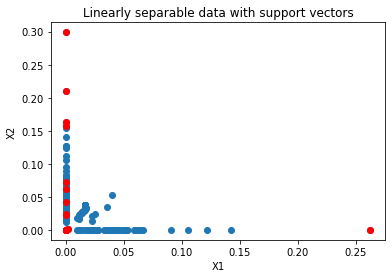

In [24]:
# Get support vectors themselves
support_vectors = clf.support_vectors_

# Visualize support vectors
plt.scatter(tv_train_features_sub[:,0].toarray(), tv_train_features_sub[:,1].toarray())
plt.scatter(support_vectors[:,0].toarray(), support_vectors[:,1].toarray(), color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [37]:
#pickle the model
# import pickle

# filename = 'svm_comp_nouns_v1.sav'
# pickle.dump(clf,open(filename,'wb'))

In [36]:
#write the 4100 important features to file
#feat_imp[feat_imp.Important == True].to_csv('C:/Users/blgai/OneDrive/Documents/School/SMU/Courses/Fall 2021/Capstone A/Feature Importance/significant_features_comp_nouns_v1.csv',index=False)